In [1]:
import os
import glob
import netCDF4
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature
import seaborn as sns

import wrf
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.colors

In [2]:
###############################################################
# CHARGE SFC variables
###############################################################

#Parameters
folder_mod = '/capstor/scratch/cscs/gsergi/OUTPUT_PGW_20220315/ANT_20220315_'
domain = 'd01'
acc_t = 1440 #minutes
ini_date_idx=0
#end_date_idx=0

###load data###
outhist_files = '/outhist/outhist_'+domain+'_*'# Load netcdf

#hist
print('Charging Ant hist...')
wrflist_oh = []
proj = 'hist'
print('Total: ' + str(np.size(glob.glob(folder_mod+proj+outhist_files))))
for i,ncdf_oh in enumerate(np.sort(glob.glob(folder_mod+proj+outhist_files))):
        print(i, end="\r")
        wrflist_oh.append(netCDF4.Dataset(ncdf_oh))
    
# Get surface variables
t2_ant_hist = wrf.getvar(wrflist_oh, 'T2', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] - 273.15
# rh_ant_hist = wrf.getvar(wrflist_oh, 'RH', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:]
psl_ant_hist = wrf.getvar(wrflist_oh, 'PSFC', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] / 100
t_ant_hist = wrf.getvar(wrflist_oh, 'T', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] 
z = wrf.getvar(wrflist_oh, "z", timeidx=wrf.ALL_TIMES)

# u10_ant_hist = wrf.getvar(wrflist_oh, 'U10', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] 
# v10_ant_hist = wrf.getvar(wrflist_oh, 'V10', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:] 
# speed10_ant_hist = np.sqrt(u10_ant_hist**2 + v10_ant_hist**2)

q= wrf.getvar(wrflist_oh, 'QVAPOR', timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:]

# q2=wrf.getvar(wrflist_oh, "Q2", timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:]
p=wrf.getvar(wrflist_oh, "PB", timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:]+wrf.getvar(wrflist_oh, "P", timeidx=wrf.ALL_TIMES)[ini_date_idx:,:,:]
p0=p.isel(bottom_top=0)
# rh_ant_hist=wrf.rh(q2, p0,t2_ant_hist+273.15) 
# rh_ant_hist=rh_ant_hist.assign_coords(Time=t2_ant_hist.Time)


######################
# ANT COORDINATES
# Get surface fix variables
height = wrf.getvar(wrflist_oh, 'HGT', timeidx=0, method="cat")[:,:]
# Get dimension
lats, lons = wrf.latlon_coords(t2_ant_hist)
times = wrf.extract_times(wrflist_oh, timeidx=wrf.ALL_TIMES)

Charging Ant hist...
Total: 59


In [3]:
def rh_to_mixing_ratio(T, RH, P):
    """
    Convert relative humidity to water vapor mixing ratio.

    Parameters:
    T  : float  -> Temperature in Celsius
    RH : float  -> Relative humidity in percentage (0-100)
    P  : float  -> Atmospheric pressure in hPa

    Returns:
    w  : float  -> Water vapor mixing ratio in kg/kg
    """
    # Compute saturation vapor pressure using Tetens' formula (hPa)
    e_s = 6.112 * np.exp((17.67 * T) / (T + 243.5))
    # Compute actual vapor pressure (hPa)
    e = (RH / 100) * e_s
    # Compute mixing ratio (kg/kg)
    w = (0.622 * e) / (P - e)
    return w

def compute_temperature_from_theta(t_hist, p, CON_xy, tRAD):
    """
    Compute temperature from potential temperature (theta).

    Parameters:
    t_hist : xarray.DataArray -> Potential temperature data
    p      : xarray.DataArray -> Pressure data
    CON_xy : tuple            -> Coordinates (x, y) for the location
    tRAD   : str              -> Time string for the specific day

    Returns:
    T      : xarray.DataArray -> Actual temperature data
    """
    R = 287.05  # J/(kg·K)
    c_p = 1004  # J/(kg·K)
    P_0 = p[:, 0, CON_xy[1], CON_xy[0]].sel(Time=tRAD)  # Pa (reference pressure)
    theta = t_hist[:, :levels, CON_xy[1], CON_xy[0]].sel(Time=tRAD) + 273.15  # Potential temperature in K
    P = p[:, :levels, CON_xy[1], CON_xy[0]].sel(Time=tRAD)
    # Convert potential temperature to actual temperature
    T = theta * (P / P_0) ** (R / c_p)
    return T

In [4]:
###############################################################
# CHARGE OBS variables
###############################################################
folder_obs='/capstor/scratch/cscs/gsergi/PROJECT_SERGI_ANT/'
CON_Obs_TPHVD = pd.read_csv(folder_obs+'/Observations/Concordia_20220301_20220331_TPHVD.txt', sep=r"\s+", parse_dates=[['DateTime', 'UTC']], index_col='DateTime_UTC')
CON_Obs_met = pd.read_csv(folder_obs+'/Observations/Concordia_AWS_meteo.tab', sep=r"\s+")

CON_RADIO=pd.read_table(folder_obs+'Observations/RDS_DOMEC_20220311_20220325.txt', sep=r"\s+")

CON_Obs=CON_Obs_TPHVD

/tmp/ipykernel_172698/156678639.py:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  CON_Obs_TPHVD = pd.read_csv(folder_obs+'/Observations/Concordia_20220301_20220331_TPHVD.txt', sep=r"\s+", parse_dates=[['DateTime', 'UTC']], index_col='DateTime_UTC')


In [5]:
CON_Obs_TPHVD['Pres']

DateTime_UTC
2022-03-01 00:00:00    643.6
2022-03-01 01:00:00    643.4
2022-03-01 02:00:00    643.1
2022-03-01 03:00:00    642.7
2022-03-01 04:00:00    642.3
                       ...  
2022-03-31 19:00:00    645.4
2022-03-31 20:00:00    645.2
2022-03-31 21:00:00    645.2
2022-03-31 22:00:00    645.2
2022-03-31 23:00:00    645.1
Name: Pres, Length: 744, dtype: float64

In [6]:
#Positions
CON_xy = wrf.ll_to_xy(wrflist_oh, -75.09978, 123.332196) #Concordia
CON_ll = wrf.xy_to_ll(wrflist_oh, CON_xy[0], CON_xy[1])

#Times mean
tini = np.where(times == np.datetime64('2022-03-17T00'))[0][0]
tend = np.where(times == np.datetime64('2022-03-20T00'))[0][0]

#Times Timeseries
tiniTS = np.where(times == np.datetime64('2022-03-10T00'))[0][0]
tendTS = np.where(times == np.datetime64('2022-03-25T00'))[0][0]

tRAD1='2022-03-18 12:00:00'
tRADObs1='2022-03-18'

tRAD2='2022-03-15 12:00:00'
tRADObs2='2022-03-15'



levels=80



# Compute temperature for the two days
T1 = compute_temperature_from_theta(t_ant_hist, p, CON_xy, tRAD1)
T2 = compute_temperature_from_theta(t_ant_hist, p, CON_xy, tRAD2)

Q1=rh_to_mixing_ratio(CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].Temp, CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].Rh, CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].Pres)
Q2=rh_to_mixing_ratio(CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].Temp, CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].Rh, CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].Pres)

height_station=3239 #m (from the radiosound data )


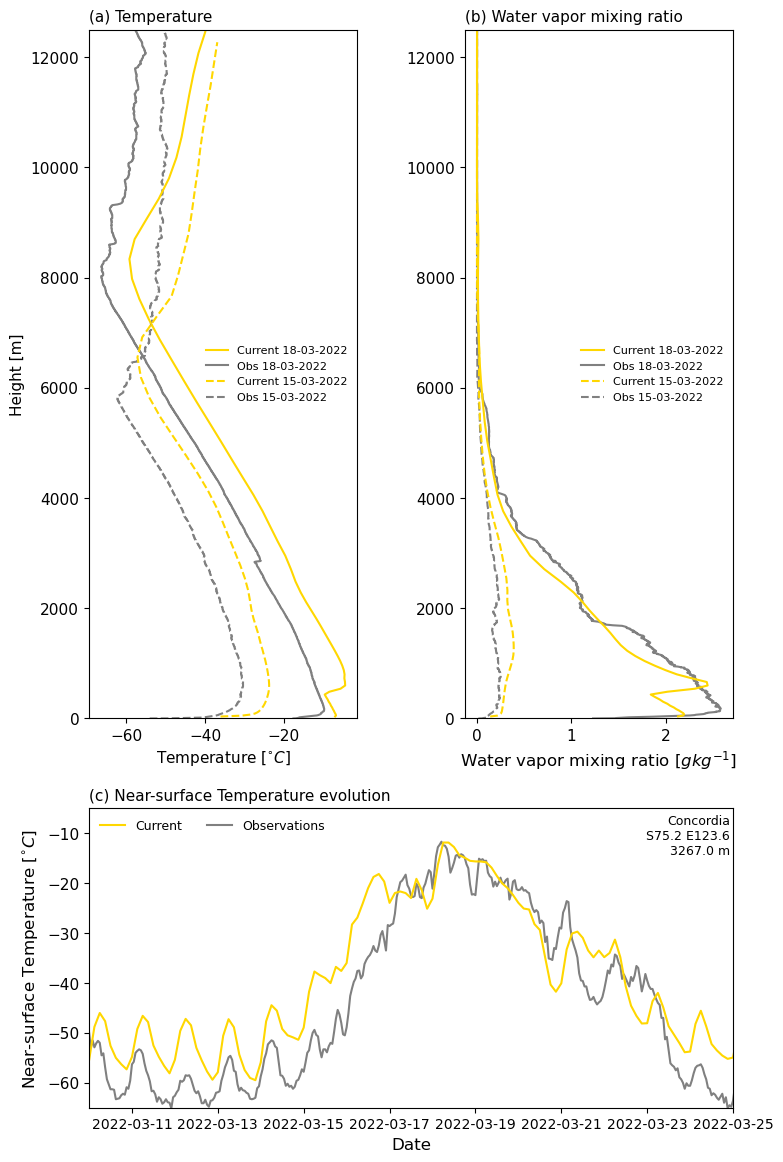

In [7]:
#############################################
# Plot 
#############################################

min_height = 10
time_ini = 39

######################################################
### Plot Starting
# Figure and axis
fig = plt.figure(figsize=[8,14])
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, hspace=0.3, wspace=0.4)

# New layout:
# ax1: left, ax2: top right, ax4: bottom right

ax1 = fig.add_subplot(spec[2, 0:])      # Left, spanning both rows
ax2 = fig.add_subplot(spec[0:2, 0])     # Top right, spanning columns 1 and 2
ax4 = fig.add_subplot(spec[0:2, 1])     # Bottom right, spanning columns 1 and 2

#-------------------------------------------
#Temperature Concordia
ax1.plot(times, t2_ant_hist[:,CON_xy[1],CON_xy[0]], c='Gold', label='Current')
ax1.plot(CON_Obs.index.values, CON_Obs['Temp'].values, c='Gray', label='Observations', zorder=-10)
ax1.text(.995, .98, 'Concordia' + '\n S' + str(-np.round(CON_ll[0].values,1)) + ' E' + str(np.round(CON_ll[1].values,1)) + '\n ' + str(np.round(height[CON_xy[1], CON_xy[0]].values, 0)) + ' m',
    horizontalalignment='right', verticalalignment='top', transform=ax1.transAxes, fontsize=9)
ax1.legend(ncol=2, loc='upper left', frameon=False, fontsize=9)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Near-surface Temperature [$^{\circ} C$]', fontsize=12)
ax1.set_ylim(-65, -5)
ax1.set_xlim(times[tiniTS], times[tendTS])
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=11)

#-------------------------------------------
#Elevation temperature
ax2.plot(T1-273.15, z[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD1)-height_station, c='Gold', label='Current 18-03-2022')
ax2.plot(CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].Temp.values, (CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].height-height_station).values, c='Gray', label='Obs 18-03-2022', zorder=-10)
ax2.plot(T2-273.15, z[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD2)-height_station, c='Gold', label='Current 15-03-2022', linestyle='--')
ax2.plot(CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].Temp.values, (CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].height-height_station).values, c='Gray', label='Obs 15-03-2022', zorder=-10, linestyle='--')
ax2.set_ylim(0,12500)
ax2.legend(loc='center right', frameon=False, fontsize=8)
ax2.set_xlabel('Temperature [$^{\circ} C$]', fontsize=11)
ax2.set_ylabel('Height [m]', fontsize=11)
# ax2.text(.995, .9, 'Concordia' + '\n S' + str(-np.round(CON_ll[0].values,1)) + ' E' + str(np.round(CON_ll[1].values,1)) + '\n ' + str(np.round(height[CON_xy[1], CON_xy[0]].values, 0)) + ' m' + '\n ',
    # horizontalalignment='right', verticalalignment='top', transform=ax2.transAxes, fontsize=9)
ax2.tick_params(axis='x', labelsize=11)
ax2.tick_params(axis='y', labelsize=11)

#Water vapor mixing ratio
ax4.plot(q[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD1)*1000, (z[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD1)-height_station).values, c='Gold', label='Current 18-03-2022')
ax4.plot(Q1.values*1000, (CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs1].height-height_station).values, c='Gray', label='Obs 18-03-2022', zorder=-10)
ax4.plot(q[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD2)*1000, (z[:,:levels,CON_xy[1], CON_xy[0]].sel(Time=tRAD2)-height_station).values, c='Gold',label='Current 15-03-2022', linestyle='--')
ax4.plot(Q2.values*1000, (CON_RADIO.loc[CON_RADIO['Sounding'] == tRADObs2].height-height_station).values, c='Gray', label='Obs 15-03-2022', zorder=-10, linestyle='--')
ax4.set_ylim(0,12500)
ax4.legend(loc='center right', frameon=False, fontsize=8)
ax4.set_xlabel('Water vapor mixing ratio [$g kg^{-1}$]', fontsize=12)
# ax4.text(.995, .9, 'Concordia' + '\n S' + str(-np.round(CON_ll[0].values,1)) + ' E' + str(np.round(CON_ll[1].values,1)) + '\n ' + str(np.round(height[CON_xy[1], CON_xy[0]].values, 0)) + ' m' + '\n ',
    # horizontalalignment='right', verticalalignment='top', transform=ax4.transAxes, fontsize=9)
ax4.tick_params(axis='x', labelsize=11)
ax4.tick_params(axis='y', labelsize=11)

####################################################
# PLOT Parameters
ax1.set_title('(c) Near-surface Temperature evolution', loc='left', fontsize=11)
ax2.set_title(f'(a) Temperature', loc='left', fontsize=11)
ax4.set_title('(b) Water vapor mixing ratio', loc='left', fontsize=11)

fig.subplots_adjust(right=0.93)
plt.savefig(folder_obs+'model_obs_comparsion2.png', dpi=300, bbox_inches='tight')
plt.show()


In [9]:
print('Observations max: ' + str(CON_Obs['Temp'].values.max()))
print('Simulation max: ' + str(t2_ant_hist[:,CON_xy[1],CON_xy[0]].values.max()))

Observations max: -11.7
Simulation max: -11.862183
